In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Input, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Attention, Concatenate

In [ ]:
# LOAD data
X_train =pd.read_csv('C:\\Users\\Dell\\Desktop\\CFM\\data\\X_train.csv')
Y_train =pd.read_csv("C:\\Users\\Dell\\Desktop\\CFM\\data\\Y_train.csv")

X_test =pd.read_csv("C:\\Users\\Dell\\Desktop\\CFM\\data\\X_test.csv")
Y_test =pd.read_csv("C:\\Users\\Dell\\Desktop\\CFM\\data\\Y_test.csv")

In [ ]:
X_train.head(5)

,obs_id,venue,order_id,action,side,price,bid,ask,bid_size,ask_size,trade,flux
0,0,4,0,A,A,0.30,0.0,0.01,100,1,False,100
1,0,4,1,A,B,-0.17,0.0,0.01,100,1,False,100
2,0,4,2,D,A,0.28,0.0,0.01,100,1,False,-100
3,0,4,3,A,A,0.30,0.0,0.01,100,1,False,100
4,0,4,4,D,A,0.37,0.0,0.01,100,1,False,-100


# <span style="color:red;">Data Preparation </span>

## <span style="color:orange;">1)Embedding training data </span>

In [ ]:
def one_hot_encode(df, column, num_categories=8):

    encoded_df = pd.get_dummies(df[column], prefix=column)

    expected_columns = [f"{column}_{i}" for i in range(num_categories)]

    for col in expected_columns:
        if col not in encoded_df.columns:
            encoded_df[col] = 0

    encoded_df = encoded_df[expected_columns]

    return encoded_df

In [ ]:
df1 = one_hot_encode(X_train, 'venue', 8)
df3 = one_hot_encode(X_train, 'trade', 8)

In [ ]:
df1.head(5)

,venue_0,venue_1,venue_2,venue_3,venue_4,venue_5,venue_6,venue_7
0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0


In [ ]:
df3.head(5)

,trade_0,trade_1,trade_2,trade_3,trade_4,trade_5,trade_6,trade_7
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0


In [ ]:
# Encodage one-hot avec 8 colonnes
encoded_columns = pd.get_dummies(X_train['action'], prefix='action')

encoded_columns['action_0'] = 0

encoded_columns = encoded_columns[['action_0'] + [col for col in encoded_columns.columns if col != 'action_0']]

# Ajout des colonnes manquantes avec des zéros si nécessaire
num_of_new_columns = 8
for i in range(num_of_new_columns - encoded_columns.shape[1]):
    encoded_columns[f'action_{encoded_columns.shape[1]}'] = 0

In [ ]:
df2=pd.DataFrame(encoded_columns)

In [ ]:
df2.head(5)

,action_0,action_A,action_D,action_U,action_4,action_5,action_6,action_7
0,0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0


In [ ]:
df3.head(5)

,trade_0,trade_1,trade_2,trade_3,trade_4,trade_5,trade_6,trade_7
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0


In [ ]:
# Log Transform
X_train['flux'] = X_train['flux'] - X_train['flux'].min() + 1
data = {
    'log(bid_size+1)': np.sign(X_train['bid_size']) * np.log(np.abs(X_train['bid_size']) + 1),
    'log(ask_size+1)': np.log(X_train['ask_size'] + 1),
    'log(flux)': np.log(X_train['flux'])
}
dfa = pd.DataFrame(data)
X_selected = X_train[['bid', 'ask', 'price']]

In [ ]:
# Combiner les features
df_combined = pd.concat([df1, df2, df3, X_selected, dfa], axis=1)


num_sequences = len(df_combined) // 100
X_reshaped = df_combined.iloc[:num_sequences * 100].values.reshape(num_sequences, 100, 30)


Y_labels = pd.get_dummies(Y_train['eqt_code_cat']).values
Y_reshaped = Y_labels[:num_sequences]

# Conversion en tenseurs
X_tensor = tf.convert_to_tensor(X_reshaped, dtype=tf.float32)
Y_tensor = tf.convert_to_tensor(Y_reshaped, dtype=tf.float32)

## <span style="color:orange;">2)Embedding test Data </span>

In [ ]:
# Appliquer le one-hot encoding aux colonnes 'venue', 'action', et 'trade' pour X_test
df1_test = one_hot_encode(X_test, 'venue', 8)
df3_test = one_hot_encode(X_test, 'trade', 8)

In [ ]:
# Encodage one-hot avec 8 colonnes
encoded_columns = pd.get_dummies(X_test['action'], prefix='action')


encoded_columns['action_0'] = 0


encoded_columns = encoded_columns[['action_0'] + [col for col in encoded_columns.columns if col != 'action_0']]

# Ajout des colonnes manquantes avec des zéros si nécessaire
num_of_new_columns = 8
for i in range(num_of_new_columns - encoded_columns.shape[1]):
    encoded_columns[f'action_{encoded_columns.shape[1]}'] = 0

In [ ]:
df2_test=pd.DataFrame(encoded_columns)

In [ ]:
#Log Transform pour X_test
X_test['flux'] = X_test['flux'] - X_test['flux'].min() + 1
data_test = {
    'log(bid_size+1)':np.sign(X_test['bid_size']) * np.log(np.abs(X_test['bid_size']) + 1),
    'log(ask_size+1)': np.log(X_test['ask_size'] + 1),
    'log(flux)': np.log(X_test['flux'])
}
dfa_test = pd.DataFrame(data_test)
X_selected_test = X_test[['bid', 'ask', 'price']]

In [ ]:
# Combiner les features pour X_test
df_combined_test = pd.concat([df1_test, df2_test, df3_test, X_selected_test, dfa_test], axis=1)


num_sequences_test = len(df_combined_test) // 100

X_combined_test = df_combined_test.iloc[:num_sequences_test * 100]


X_reshaped_test = X_combined_test.values.reshape(num_sequences_test, 100, 30)


Y_labels_test = pd.get_dummies(Y_test['eqt_code_cat']).values


Y_reshaped_test = Y_labels_test[:num_sequences_test]

# Conversion en tenseurs pour X_test et Y_test
X_tensor_test = tf.convert_to_tensor(X_reshaped_test, dtype=tf.float32)
Y_tensor_test = tf.convert_to_tensor(Y_reshaped_test, dtype=tf.float32)

# <span style="color:red;">Creation de modele </span>

In [ ]:

# Définir la taille d'une observation
sequence_length = 100
feature_dim = 30

# Définir l'entrée du modèle
input_layer = Input(shape=(sequence_length, feature_dim))

# Ajouter des couches GRU bidirectionnelles avec Dropout et Batch Normalization
gru_1 = Bidirectional(GRU(64, return_sequences=True))(input_layer)
dropout_1 = Dropout(0.2)(gru_1)
batch_norm_1 = BatchNormalization()(dropout_1)

# mécanisme d'attention après la première couche GRU bidirectionnelle
attention = Attention()([batch_norm_1, batch_norm_1])
concatenated = Concatenate()([attention, batch_norm_1])


gru_2 = Bidirectional(GRU(64))(batch_norm_1)
dropout_2 = Dropout(0.2)(gru_2)
batch_norm_2 = BatchNormalization()(dropout_2)

# Ajouter des couches Denses
dense_1 = Dense(128, activation='selu')(batch_norm_2)
dropout_3 = Dropout(0.2)(dense_1)
dense_2 = Dense(64, activation='selu')(dropout_3)
output_layer = Dense(24, activation='softmax')(dense_2)

# Créer le modèle
model = Model(inputs=input_layer, outputs=output_layer)

# Compiler le modèle
optimizer = Adam(learning_rate=3e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Afficher un résumé du modèle
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 30)]         0         
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          36864     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 batch_normalization (Batch  (None, 100, 128)          512       
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                                            

In [ ]:
# Compiler le modèle
optimizer = Adam(learning_rate=3e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Afficher un résumé du modèle
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 30)]         0         
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          36864     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 batch_normalization (Batch  (None, 100, 128)          512       
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                                             

# <span style="color:red;">Entrainement de modele </span>

In [ ]:
# Définir le callback EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

# Entraîner le modèle avec EarlyStopping
history = model.fit(
    X_tensor, Y_tensor,
    validation_split=0.2,
    batch_size=1000,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/40


116/116 [==============================] - 171s 1s/step - loss: 2.6120 - accuracy: 0.1718 - val_loss: 2.8660 - val_accuracy: 0.1400
Epoch 2/40
116/116 [==============================] - 737s 6s/step - loss: 2.1739 - accuracy: 0.2720 - val_loss: 2.1643 - val_accuracy: 0.2801
Epoch 3/40
116/116 [==============================] - 160s 1s/step - loss: 2.0424 - accuracy: 0.3131 - val_loss: 1.9815 - val_accuracy: 0.3232
Epoch 4/40
116/116 [==============================] - 403s 3s/step - loss: 1.8903 - accuracy: 0.3551 - val_loss: 1.8273 - val_accuracy: 0.3639
Epoch 5/40
116/116 [==============================] - 162s 1s/step - loss: 1.7542 - accuracy: 0.3956 - val_loss: 1.7447 - val_accuracy: 0.4023
Epoch 6/40
116/116 [==============================] - 166s 1s/step - loss: 1.6611 - accuracy: 0.4246 - val_loss: 1.7654 - val_accuracy: 0.4009
Epoch 7/40
116/116 [==============================] - 190s 2s/step - loss: 1.5853 - accuracy: 0.4492 - val_loss: 1.5781 - val_accuracy: 0.44

In [ ]:
# Sauvegarder les poids du modèle
model.save_weights('model_weights.h5')

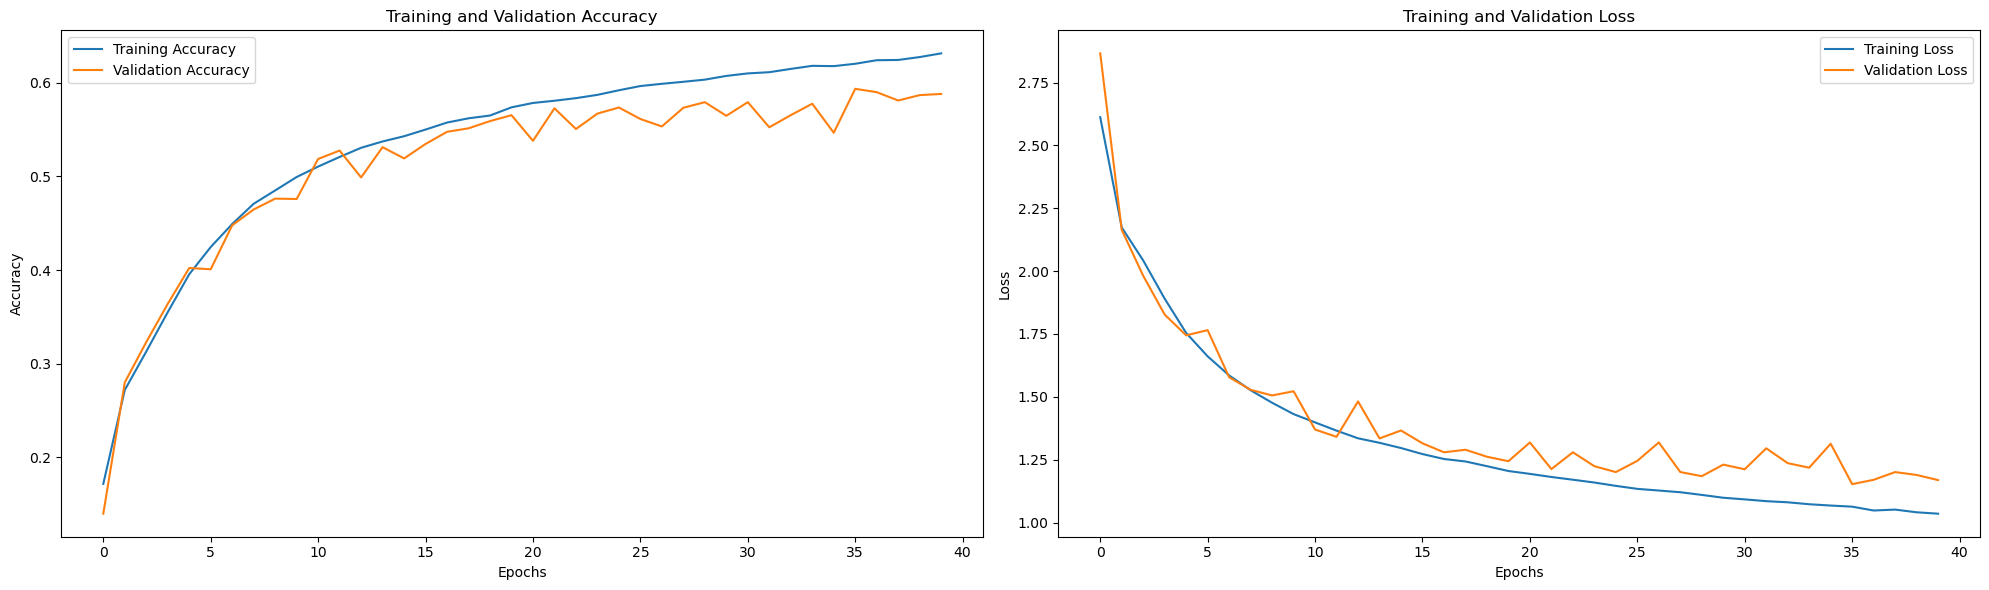

In [ ]:
import matplotlib.pyplot as plt

# Fonction pour tracer les courbes d'accuracy et de validation accuracy et de loss et de validation loss dans la même ligne
def plot_accuracy_and_loss(history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    # Accuracy subplot
    ax[0].plot(history.history['accuracy'], label='Training Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Loss subplot
    ax[1].plot(history.history['loss'], label='Training Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Training and Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Tracer les courbes
plot_accuracy_and_loss(history)

# <span style="color:red;">Evaluation de modele </span>

In [ ]:
# Évaluer le modèle sur l'ensemble de test
loss, accuracy = model.evaluate(X_tensor_test, Y_tensor_test, verbose=0)
print(f'Précision sur l\'ensemble de test: {accuracy}')

# Faire des prédictions et évaluer les performances
y_pred = model.predict(X_tensor_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(Y_reshaped_test, axis=1)

print('Rapport de classification:')
print(classification_report(y_true, y_pred_classes))
print('Matrice de confusion:')
print(confusion_matrix(y_true, y_pred_classes))

Précision sur l'ensemble de test: 0.5838930606842041
503/503 [==============================] - 17s 31ms/step
Rapport de classification:
              precision    recall  f1-score   support

           0       0.48      0.80      0.60       670
           1       0.55      0.52      0.53       670
           2       0.44      0.51      0.47       670
           3       0.48      0.60      0.53       670
           4       0.62      0.43      0.51       670
           5       0.58      0.54      0.56       670
           6       0.65      0.63      0.64       670
           7       0.67      0.39      0.49       670
           8       0.74      0.82      0.78       670
           9       0.58      0.48      0.52       670
          10       0.69      0.50      0.58       670
          11       0.59      0.57      0.58       670
          12       0.59      0.62      0.60       670
          13       0.57      0.69      0.63       670
          14       0.65      0.61      0.63       67

In [ ]:
model.save('model.h5')

C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# <span style="color:red;">Soumission </span>

In [ ]:
# Load final test data
X_test_final = pd.read_csv("D:\\desktopnisrine\\PFA\\Data\\X_test_m4HAPAP.csv")

In [ ]:
print(X_test_final.shape)

(8160000, 12)


In [ ]:
# One-hot encoding pour colonnes 'venue' and 'trade'
df1_testf = one_hot_encode(X_test_final, 'venue', 8)
df3_testf = one_hot_encode(X_test_final, 'trade', 8)

# One-hot encoding pour colonne 'action'
encoded_columnsf = pd.get_dummies(X_test_final['action'], prefix='action')

# Ensure 'action_0' column exists and is set to zero
if 'action_0' not in encoded_columnsf.columns:
    encoded_columnsf['action_0'] = 0

for i in range(8):
    col_name = f'action_{i}'
    if col_name not in encoded_columnsf.columns:
        encoded_columnsf[col_name] = 0


ordered_columns = ['action_0'] + [f'action_{i}' for i in range(1, 8)]
encoded_columnsf = encoded_columnsf[ordered_columns]

df2_testf = pd.DataFrame(encoded_columnsf)

# Log Transform pour certain colonnes
X_test_final['flux'] = X_test_final['flux'] - X_test_final['flux'].min() + 1
data_testf = {
    'log(bid_size+1)': np.sign(X_test_final['bid_size']) * np.log(np.abs(X_test_final['bid_size']) + 1),
    'log(ask_size+1)': np.log(X_test_final['ask_size'] + 1),
    'log(flux)': np.log(X_test_final['flux'])
}
dfa_testf = pd.DataFrame(data_testf)


X_selected_testf = X_test_final[['bid', 'ask', 'price']]


df_combined_testf = pd.concat([df1_testf, df2_testf, df3_testf, X_selected_testf, dfa_testf], axis=1)

num_sequences_testf = len(df_combined_testf) // 100
X_combined_testf = df_combined_testf.iloc[:num_sequences_testf * 100]

num_features = X_combined_testf.shape[1]
print(f"Number of features: {num_features}")


X_reshaped_testf = X_combined_testf.values.reshape(num_sequences_testf, 100, num_features)

# Convert to tensor
X_tensor_testf = tf.convert_to_tensor(X_reshaped_testf, dtype=tf.float32)

Number of features: 30


In [ ]:
from keras.models import load_model

model = load_model('model.h5')


y_pred = model.predict(X_tensor_testf)

# Convert predictions to class labels
y_pred_class = np.argmax(y_pred, axis=1)

Sobs_id = X_test_final['obs_id'][:len(y_pred_class) * 100:100]


df_predictions = pd.DataFrame({
    'obs_id': obs_id,
    'Prediction': y_pred_class
})

# Save predictions to a CSV file
df_predictions.to_csv('predictions.csv', index=False)

2550/2550 [==============================] - 92s 35ms/step


In [ ]:
print("Predictions saved to 'predictions.csv'.")

Predictions saved to 'predictions.csv'.


In [ ]:
# Charger le fichier predictions.csv
df_predictions = pd.read_csv('predictions.csv')

# Compter le nombre d'éléments dans chaque classe
class_counts = df_predictions['Prediction'].value_counts()

# Afficher le résultat
print(class_counts)

16    9021
19    6499
12    6466
0     6219
15    5999
9     5779
6     5655
4     4356
11    3906
13    3841
1     3211
14    2923
8     2460
17    2358
3     2195
18    2159
22    1927
10    1770
7     1441
23    1354
20     993
5      505
21     383
2      180
Name: Prediction, dtype: int64


In [ ]:
import json

# Définir les hyperparamètres
hyperparameters = {
    'sequence_length': 100,
    'feature_dim': 30,
    'gru_units': 64,
    'dropout_rate': 0.2,
    'dense_units': [128, 64],
    'activation': 'selu',
    'output_units': 24,
    'output_activation': 'softmax',
    'optimizer': 'adam',
    'learning_rate': 3e-3,
    'loss': 'categorical_crossentropy',
    'batch_size': 1000,
    'epochs': 100,
    'patience': 10
}

# Sauvegarder les hyperparamètres dans un fichier JSON
with open('hyperparameters.json', 'w') as f:
    json.dump(hyperparameters, f, indent=4)

In [ ]:
print(df_predictions.shape)

(81600, 2)
